In [1]:
import os
import sys
import cv2 as cv
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import color, data, filters, morphology, restoration
from skimage.measure import shannon_entropy
from scipy import ndimage as nd
from scipy.spatial import distance as sc_distance
from skimage.feature import peak_local_max, canny
from skimage.segmentation import watershed
import torch
import torchvision.ops.boxes as bops
src_path = os.path.abspath(os.path.join(os.path.abspath(''), '../'))
sys.path.append(src_path)
import blob_class as bc
import blob_detection as bd
import contrast_functions as cf
import param_output as po

In [2]:
def rescale_image(image, min_pixel=0.35, max_pixel=99.65):
    # Calculate the minimum and maximum pixel intensities for rescaling
    percentile_0 = np.percentile(image, min_pixel)
    percentile_100 = np.percentile(image, max_pixel)

    # Rescale the image
    rescaled_image = np.clip(image, percentile_0, percentile_100)
    rescaled_image = ((rescaled_image - percentile_0) / (percentile_100 - percentile_0)) * 255
    rescaled_image = rescaled_image.astype(np.uint8)

    return rescaled_image

In [3]:
#from skimage import restoration, color
#from scipy import ndimage as nd
#import numpy as np

def estimate_noise(image):
    """
    Estimate the noise of an image using the MAD method
    """
    # Convert the image to grayscale if it's RGB
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
        
    # Median filter the image
    med = nd.median_filter(image, 5)
    
    # Calculate the absolute difference between the original image and the median image
    mad = np.mean(np.abs(image - med))
    
    return mad

def denoise_image(image, threshold):
    """
    De-noise the image using non-local means, altering h parameter until noise is below threshold.
    """
    # Initial h value
    h = 0.1
    # Increment h value
    increment = 0.1

    # Measure the noise
    noise = estimate_noise(image)
    
    # Return the original image if the noise is already less than the threshold
    if noise < threshold:
        return image

    while noise > threshold:
        denoised = restoration.denoise_nl_means(image, h=h, fast_mode=True)
        noise = estimate_noise(denoised)
        h += increment

    return denoised

In [4]:
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt

def enhance_contrast(image, method='histogram_eq'):
    """
    Enhance the contrast of the image.
    Parameters:
    - image : The input image.
    - method: The contrast enhancing method, can be 'histogram_eq', 'adaptive_histogram_eq', 'contrast_stretching', 'log_transform', 'power_law_transform', 'sigmoid_correction', 'clahe'
    Returns:
    - The contrast enhanced image.
    """

    # Convert image to uint8, necessary for some methods
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    if method == 'histogram_eq':
        return cv2.equalizeHist(image)
    elif method == 'adaptive_histogram_eq':
        return exposure.equalize_adapthist(image, clip_limit=0.03)
    elif method == 'contrast_stretching':
        p2, p98 = np.percentile(image, (2, 98))
        return exposure.rescale_intensity(image, in_range=(p2, p98))
    elif method == 'log_transform':
        c = 255 / np.log(1 + np.max(image))
        log_image = c * (np.log(image + 1))
        return np.array(log_image, dtype=np.uint8)
    elif method == 'power_law_transform':
        gamma = 0.5  # Gamma < 1 decreases the influence of high intensity values
        return np.array(255*(image / 255) ** gamma, dtype = 'uint8')
    elif method == 'sigmoid_correction':
        return exposure.adjust_sigmoid(image)
    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(image)
    else:
        print("Invalid contrast enhancement method. Choose either 'histogram_eq', 'adaptive_histogram_eq', 'contrast_stretching', 'log_transform', 'power_law_transform', 'sigmoid_correction', or 'clahe'.")
        return image

In [5]:
def blob_nuclei(image, min_percent_area=10):
    """
    Finds cell nuclei in an image

    Parameters
    ----------
    image : image matrix
        input image

    min_percent_area : int or float
        Minimum percent of image area to be considered
        an actual nuclei

    Returns
    -------
    blob_nuclei: list of Blob objects
        A list of blob nuclei found in image
    """

    # find edges in the image
    edges = filters.sobel(image)
    edges = cf.percentile_rescale(edges, 0.35, 99.65)

    # make binary image
    thresh = filters.threshold_li(edges)
    _ , im_binary = cv.threshold(edges, thresh, 255, cv.THRESH_BINARY)
    
    # find and sort contours by area - largest first
    contours, _ = cv.findContours(im_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    
    # find min_area
    shape = im_gray.shape
    ax1 = shape[0] * min_percent_area / 100
    ax2 = shape[1] * min_percent_area / 100
    min_area = ax1 * ax2
    
    # get blob_nuclei which are above correct size
    # have to make Blob object to get pixel area
    blob_nuclei = []
    for cont in contours:
        # create Blob object
        blob = bc.Blob(cont, image)

        # append blob if large enough
        if blob.area_filled > min_area:
            blob_nuclei.append(blob)

        # else break as next blob would be smaller
        else:
            break
        
    return blob_nuclei

In [133]:
def maxima_filter(contour, local_maxima):

    if len(local_maxima) == 0:
        return None, None
    # points is list of booleans
    # True in each index that maxima is inside contour
    points = np.array([cv.pointPolygonTest(np.array(contour),
                                           (int(maxima[0]), int(maxima[1])),
                                           False)
                       for maxima in local_maxima])

    if np.sum(points == 1) >= 1:  # if maxima found
        idxs = np.where(points == 1)  # points are true
        maxima = np.array(local_maxima)[idxs]
        return maxima, idxs[0]

    # return None if no maxima found
    return None, None

def get_contours(image, min_length=5, thresh_min=0, thresh_max=255, thresh_step=10, thresh_compare=20):
    # may want to calculate min_length (perimeter) based on min area of circle
    
    im = image.copy()
    # get list of values to calculate
    thresh_vals = []
    for i in range(thresh_max, thresh_min, -thresh_step):
        thresh_vals.append(i)
        thresh_vals.append(i-thresh_compare)
    thresh_vals = np.sort(np.unique(np.array(thresh_vals)))[::-1]
    print(thresh_vals)
    
    all_contours = []
    im_thresh = {}
    for i in thresh_vals:
        im[im >= i] = 0
        im_binary = cv.threshold(im, 0.5, 255, cv.THRESH_BINARY)[1]
        contours, hierarchy = cv.findContours(im_binary,
                                        cv.RETR_CCOMP,
                                        cv.CHAIN_APPROX_NONE)
        im_contours = []
        im_maxima = []
        if hierarchy is not None:
            hierarchy = hierarchy[0]
            for j, row in enumerate(hierarchy):
                if len(contours[j]) >= min_length:
                    if row[2] == -1 and row[3] != -1:
                        #all_contours.append(contours[j]) # includes more contours than needed
                        im_contours.append(contours[j])
                        im_maxima.append(np.mean(contours[j], axis=0)[0].astype(int))
        
        im_thresh[i] = [im_binary, im_contours, im_maxima]
        # FOR DEMO - use threshold = 25
        #cv.imwrite("ex_binary_" + str(i) + ".jpg", cv.threshold(im, 0.5, 255, cv.THRESH_BINARY)[1])
    
    all_contours = []
    for i in range(thresh_max, thresh_min, -thresh_step):
        all_contours = all_contours + im_thresh[i][1]
    
    all_maxima = []
    """
    for i in range(thresh_max, thresh_min, -thresh_step):
        for maxima in im_thresh[i][2]:
            for contour in im_thresh[i-thresh_compare][1]:
                hit_flag = False
                pts, idxs = maxima_filter(contour, all_maxima + [maxima])
                if pts is not None and maxima in pts:
                    if len(pts) != 1:
                        hit_flag = True
                        break
            if hit_flag == False:
                all_maxima.append(maxima)
                
    """
    # same as above code but probably slower
    for i in range(thresh_max, thresh_min, -thresh_step):
        for maxima in im_thresh[i][2]:
            # find out if maxima is part of contour of another maxima when thresholded lower (threshold - thresh_compare)
            maxima_idxs = [maxima_filter(contour, all_maxima + [maxima])[0] for contour in im_thresh[i-thresh_compare][1]]
            maxima_idxs = [len(maxi) for maxi in maxima_idxs if maxi is not None and maxima in maxi]
            if len(maxima_idxs) > 0 and max(maxima_idxs) == 1:
                all_maxima.append(maxima)
    
    return all_contours, all_maxima

def get_contours2(image, min_length=5, thresh_min=50, thresh_max=255, thresh_step=10, maxima_thresh = 127, thresh_diff_limit=30):
    im = image.copy()
    all_maxima = {}
    all_contours = {}
    all_contours_list = []

    # Step 1: Gather all maxima and contours at different thresholds
    for thresh in range(thresh_max, thresh_min - thresh_diff_limit, -thresh_step):
        _, im_binary = cv.threshold(im, thresh, 255, cv.THRESH_BINARY)
        contours, _ = cv.findContours(im_binary, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
        maxima_at_thresh = []
        contours_at_thresh = []
        for contour in contours:
            if len(contour) >= min_length:
                maxima = tuple(np.mean(contour, axis=0)[0].astype(int))
                maxima_at_thresh.append(maxima)
                contours_at_thresh.append(contour)
                all_contours_list.append(contour)
        all_maxima[thresh] = maxima_at_thresh
        all_contours[thresh] = contours_at_thresh

    # Step 2: Filter maxima based on overlap criteria
    filtered_maxima = []
    for thresh_high in range(thresh_max, max(maxima_thresh, thresh_min), -thresh_step):
        maxima_at_high_thresh = all_maxima[thresh_high]
        maxima_considered = filtered_maxima + maxima_at_high_thresh
        contours_at_low_thresh = all_contours.get(thresh_high - thresh_diff_limit, [])
        for contour_low in contours_at_low_thresh:
            maxima_in_contour_low, idxs = maxima_filter(contour_low, maxima_considered)
            if maxima_in_contour_low is not None:
                if len(maxima_in_contour_low) == 1:
                    filtered_maxima.append(tuple(maxima_in_contour_low[0]))
                else:
                    # check if any of the maxima already in filtered_maxima
                    maxima_in_filtered = any([tuple(maxima_in_contour_low[i]) in filtered_maxima 
                                              for i in range(len(maxima_in_contour_low))])
                    # if no maxima already in filtered_maxima, append first to list (doesn't matter which maxima, just need one)
                    if not maxima_in_filtered:
                        filtered_maxima.append(tuple(maxima_in_contour_low[0]))
                        

    return all_contours_list, filtered_maxima


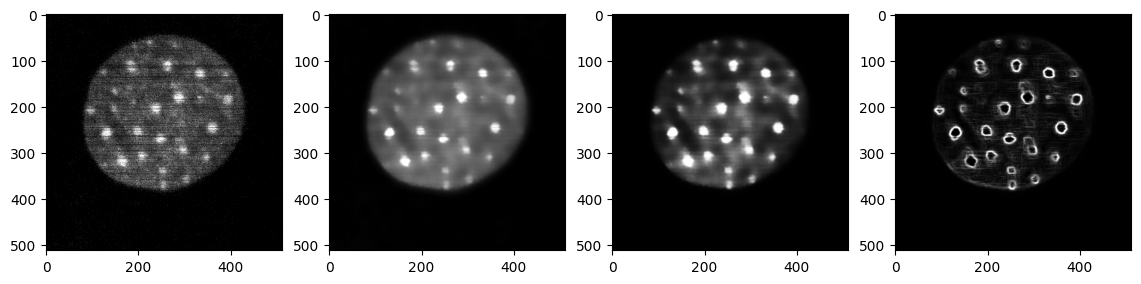

In [78]:
### May need to include nucleus as blob - find contour from im_blur
### nuc_blob = bc.Blob(nuc_blur.cv_contour, nuc_fill)

im = cv2.imread('../example_images/ex1.tif')
im = rescale_image(im)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
im_blur = denoise_image(im_gray, threshold = 0.005)
im_blur = rescale_image(im_blur)
im_cont = enhance_contrast(im_blur, method='sigmoid_correction')
edges = filters.sobel(im_cont)
edges = cf.percentile_rescale(edges, 0.35, 99.65)
    
fig = plt.figure(figsize = (14,5))
fig.add_subplot(1, 4, 1)
plt.imshow(im, cmap = "gray")
fig.add_subplot(1, 4, 2)
plt.imshow(im_blur, cmap = "gray")
fig.add_subplot(1, 4, 3)
plt.imshow(im_cont, cmap='gray')
fig.add_subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')

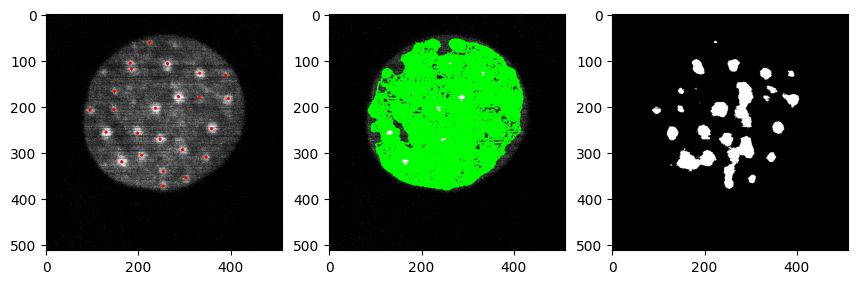

In [145]:
#contours, maxima = get_contours(im_cont, thresh_min=50, thresh_step=10, thresh_compare=20)
contours, maxima = get_contours2(im_cont, thresh_min=50, thresh_step=5, maxima_thresh=100, thresh_diff_limit=30)

im_maxima = im.copy()
for coordinate in maxima:
    cv.circle(im_maxima, (coordinate), 2, (255,0,0), 2)
    
im_contour = im.copy()
cv.drawContours(im_contour, contours, -1, (0,255,0), 2)

_, im_binary = cv.threshold(im_cont, 100, 255, cv.THRESH_BINARY)
    
fig = plt.figure(figsize = (14,5))
fig.add_subplot(1, 4, 1)
plt.imshow(im_maxima, cmap = "gray")
fig.add_subplot(1, 4, 2)
plt.imshow(im_contour, cmap = "gray")
fig.add_subplot(1, 4, 3)
plt.imshow(im_binary, cmap='gray')
#fig.add_subplot(1, 4, 4)
#plt.imshow(edges, cmap='gray')